In [1]:
from __future__ import absolute_import
from __future__ import print_function
import PIL
import torch
import glob as gb
import numpy as np
from PIL import Image
import os
import random
import torch.nn as nn

model_path = '/home/angelo/Desktop/Github/Feature-Extractors/'
os.sys.path.append(model_path)

from numpy import dot
from numpy.linalg import norm
import matplotlib.pyplot as plt

In [119]:
# hyper parameters
mean = (131.0912, 103.8827, 91.4953)

def cos_sim(a,b):
    return dot(a, b)/(norm(a)*norm(b))

def euc_dis(a,b):
    return norm(a-b)

def load_data(path='', shape=(224,224,3)):
    short_size = 224.0
    crop_size = shape
    img = PIL.Image.open(path)
    
    im_shape = np.array(img.size)    # in the format of (width, height, *)
    img = img.convert('RGB')

    ratio = float(short_size) / np.min(im_shape)
    img = img.resize(size=(int(np.ceil(im_shape[0] * ratio)),   # width
                           int(np.ceil(im_shape[1] * ratio))),  # height
                           resample=PIL.Image.BICUBIC)

    x = np.array(img)  # image has been transposed into (height, width)
    newshape = x.shape[:2]
    h_start = (newshape[0] - crop_size[0])//2
    w_start = (newshape[1] - crop_size[1])//2
    x = x[h_start:h_start+crop_size[0], w_start:w_start+crop_size[1]]
    x = x - mean
    return x


def chunks(l, n):
    # For item i in a range that is a length of l,
    for i in range(0, len(l), n):
        # Create an index range for l of n items:
        yield l[i:i+n]

def initialize_senet50():
    import senet50_128_pytorch.senet50_128 as model
    network = model.senet50_128(weights_path=model_path + 'senet50_128_pytorch/senet50_128.pth')
    network.eval()
    return network

def initialize_resnet50():
    import resnet50_128_pytorch.resnet50_128 as model
    network = model.resnet50_128(weights_path=model_path + 'resnet50_128_pytorch/resnet50_128.pth')
    network.eval()
    return network

def image_encoding(model, facepaths, batch_size):
    print('==> compute image-level feature encoding.')
    num_faces = len(facepaths)
    face_feats = np.empty((num_faces, 128))
    imgpaths = facepaths
    imgchunks = list(chunks(imgpaths, batch_size))

    for c, imgs in enumerate(imgchunks):
        im_array = np.array([load_data(path=i, shape=(224, 224, 3)) for i in imgs])
        f = model(torch.Tensor(im_array.transpose(0, 3, 1, 2)))[1].detach().cpu().numpy()[:, :, 0, 0]
        start = c * batch_size
        end = min((c + 1) * batch_size, num_faces)
        # This is different from the Keras model where the normalization has been done inside the model.
        face_feats[start:end] = f / np.sqrt(np.sum(f ** 2, -1, keepdims=True))
        if c % 50 == 0:
            print('-> finish encoding {} images.'.format(num_faces))
    return face_feats


def return_embedding(model, image):
    face_feats = np.empty((1,128)) # Embedding size
    im_array = np.array(image).reshape((1,3,224,224))
    f = model(torch.Tensor(im_array))[1].detach().cpu().numpy()[:, :, 0, 0]
    face_feats = f / np.sqrt(np.sum(f ** 2, -1, keepdims=True)) # Normalizing embedding
    return face_feats.reshape(-1)

def return_activations(model, image):
    activations = list()
    normalized_values = 0
    im_array = np.array(image).reshape((1,3,224,224))
    for i in range(2,7):
        f = model(torch.Tensor(im_array))[i].detach().cpu().numpy()[:, :, 0, 0]
        normalized_values = f / np.sqrt(np.sum(f ** 2, -1, keepdims=True))
        activations.append(normalized_values.reshape(-1))
    return np.array(activations)

def face_perception_loss(model, img1, img2):
    
    activations_img1 = return_activations(model, img1)
    activations_img2 = return_activations(model, img2)
    loss = 0
    
    # L1 Error or L2 Error or Euclidean Distance
    for layer in range(len(activations_img1)):
        #loss += np.abs(sum(activations_img1[layer] - activations_img2[layer]))
        loss += np.sum((activations_img1[layer] - activations_img2[layer])**2)
        #loss += euc_dis(activations_img1[layer], activations_img2[layer])
    return loss

In [3]:
senet50 = initialize_senet50()

In [124]:
low_res_img_path = '/media/angelo/DATEN/Datasets/CelebA/LR_112/test/018500.jpg'
original_img_path = '/media/angelo/DATEN/Datasets/CelebA/HR/test/018500.jpg'

lr_img = load_data(low_res_img_path)
hr_img = load_data(original_img_path)

lr_emb = return_embedding(senet50, lr_img)
hr_emb = return_embedding(senet50, hr_img)

print('Identity Loss')
print(1 - cos_sim(lr_emb, hr_emb))
      
print('Perceptual Loss')
print(face_perception_loss(senet50, lr_img, hr_img))

Identity Loss
0.002061009407043457
Perceptual Loss
0.06567422114312649


In [159]:
img_path = '/media/angelo/DATEN/Datasets/ICB-RW/'

gallery_path = gb.glob(img_path + 'gallery/*.jpg')
gallery_names = np.array([os.path.splitext(name)[0][:-2] for name in os.listdir(img_path + 'gallery/')])

model_eval = initialize_resnet50()
face_embeddings = image_encoding(model_eval, gallery_path)

==> compute image-level feature encoding.
-> finish encoding 30 images.


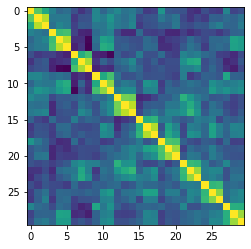

In [160]:
# Checking distances

S = np.dot(face_embeddings, face_embeddings.T)

plt.imshow(S)
plt.show()

In [161]:
from sklearn.metrics import confusion_matrix,f1_score, accuracy_score
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(metric='euclidean',n_neighbors=1)

knn.fit(face_embeddings, gallery_names)

acc_knn = accuracy_score(gallery_names, knn.predict(face_embeddings))
print(acc_knn)
confusion_matrix(gallery_names, knn.predict(face_embeddings))

1.0


array([[3, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 3, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 3, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 3, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 3, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 3, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 3, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 3, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 3, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 3]])

In [162]:
img_path = '/media/angelo/DATEN/Datasets/ICB-RW/probe/'

probe_images = gb.glob(img_path + '/*.jpg')
probe_names = np.array([os.path.splitext(name)[0][:-2] for name in os.listdir(img_path)])

test_embeddings = image_encoding(model_eval, probe_images)
predictions = knn.predict(test_embeddings)

knn_matrix = confusion_matrix(probe_names, predictions)
print(accuracy_score(probe_names, predictions))
knn_matrix

==> compute image-level feature encoding.
-> finish encoding 50 images.
0.82


array([[3, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 5, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 5, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 4, 0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 2, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 5, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 1, 3, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 4, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 5, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 5]])

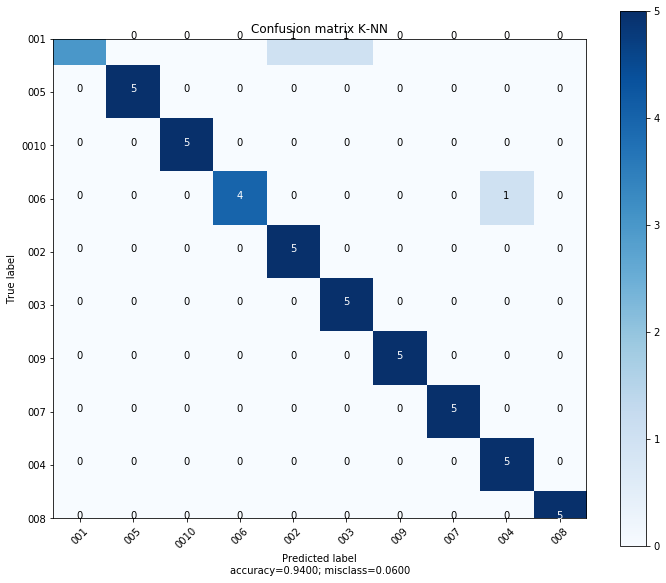

In [158]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

class_names = list(set(probe_names))

plot_confusion_matrix(knn_matrix, class_names,
                      title='Confusion matrix K-NN', cmap=None,
                          normalize=False)

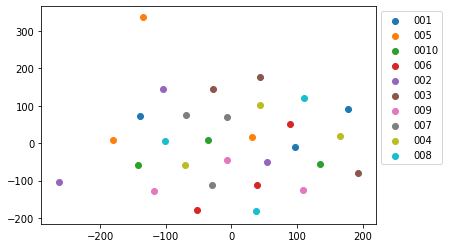

In [82]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

X_embedded = TSNE(n_components=2).fit_transform(face_embeddings)

for i, t in enumerate(set(gallery_names)):
    idx = gallery_names == t
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)   

plt.legend(bbox_to_anchor=(1, 1));

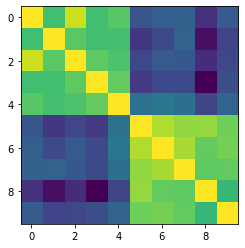

In [101]:
# Checking distances

distances = np.array([cos_sim(feature1, feature2) for feature1 in face_feats for feature2 in face_feats])

distances = np.reshape(distances, [10,10])

plt.imshow(distances)